In [36]:
from qiskit import QuantumCircuit, execute, Aer, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.visualization import plot_histogram
import math

In [33]:
def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

In [40]:
noise_model = get_noise(0.01)

In [120]:
aer_sim = Aer.get_backend('aer_simulator')
count_list = []
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure([0, 1], [0, 1])
#     display(qc.draw(output='mpl'))
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc)
    counts = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()
    count_list.append(counts)
    print(state+' becomes', counts)

00 becomes {'00': 9814, '10': 98, '01': 88}
01 becomes {'01': 9800, '11': 95, '00': 105}
10 becomes {'10': 9807, '11': 92, '00': 101}
11 becomes {'11': 9793, '00': 2, '10': 99, '01': 106}


In [47]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure([0, 1], [0, 1])
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
noisy = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result().get_counts()
print("Noisy : ",noisy)
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(qc, qasm_sim)
qobj = assemble(t_qc)
ideal = aer_sim.run(qobj, shots=10000).result().get_counts()
print("Ideal : ",ideal)

Noisy :  {'00': 4932, '11': 4872, '10': 100, '01': 96}
Ideal :  {'00': 4957, '11': 5043}


In [147]:
import numpy as np
np.set_printoptions(suppress=True)
import collections
def get_vec(res, maxlen = None, basis = None):
    #We add this bit if code to complete our bitstring in cas we have, for example, the distribution
    #['00','10','11'] and we miss ['01'] because the simulation never encountered it
    if maxlen is None : 
        maxlen = len(res)
    if basis is None : 
        log = int(math.log2(maxlen))
        basis = [format(i,"b").zfill(log) for i in range(0,maxlen)]
    
    
    if(len(res) < maxlen):
        for c in basis:
            if c not in res:
                res[c] = 0
    return(np.fromiter(collections.OrderedDict(sorted(res.items())).values(), dtype = int))

In [154]:
def make_mat(count_list, classical_size, shots_amount, basis):
    #To compute the noise matrix, we first need to extract the probability of getting each bitstring from the dictionnary
    #and order them in the lexicographic order
    #Each vector is normalized
    mat = np.zeros((len(count_list),len(count_list)))
    for i,count in enumerate(count_list):
        vec = get_vec(count, classical_size, basis)/shots_amount
        mat[:,i] = vec
    return(mat)

def compute_noise_matrix(backend, classical_size):
    log = int(math.log2(classical_size))
    #we compute a list of string representing the classical basis. 
    #For classical_size = 4, the basis is ['00','01','10','11']
    basis = [format(i,"b").zfill(log) for i in range(0,classical_size)]
    count_list = []
    for state in basis:
        #We generate a circuit of the appropriate size to handle the bitstring in the basis vector
        #For example, we need two qubits to encode the bitstring '10'
        #X gates are also applied by considering the bit string and the way the qubits will be measured.
        #For example, if we encode the bit string '01', we want the state |10>
        qc = QuantumCircuit(log,log)
        for i in range(len(state)):
            if(state[i] == '1'):
                qc.x(len(state)-i-1)
        qc.measure(range(log),range(log))
        t_qc = transpile(qc, backend)
        qobj = assemble(t_qc)
        shots_amount = 10000
        counts = aer_sim.run(qobj, noise_model=noise_model, shots=shots_amount).result().get_counts()
        count_list.append(counts)
    #Once all the shots have been computed for each circuits, we compute the noise matrix and return it
    return(make_mat(count_list, classical_size, shots_amount, basis))
    
backend = Aer.get_backend('aer_simulator')
compute_noise_matrix(backend,4)

array([[0.9814, 0.0093, 0.0116, 0.0003],
       [0.0091, 0.982 , 0.0001, 0.0086],
       [0.0095, 0.    , 0.978 , 0.009 ],
       [0.    , 0.0087, 0.0103, 0.9821]])

By determining the error distribution in the basis state, we can build a matrix to mitigate the errors on the machine/simulator we are using. 
After building the matrix, we can inverse it to get the ideal bitstring from a noisy bitstring.
The formula is the following:
$$C_{Ideal} = M^{-1} C_{Noisy}$$
By taking our vector $noisy$ and multiplying it with the result of make_mat, we have a cleaned versions of the result of our simulation.

In [156]:
def correct(vec, mat=None, backend = None):
    import scipy.linalg as la
    if mat is None:
        if backend is None:
            backend = Aer.get_backend('aer_simulator')
        mat = compute_noise_matrix(backend,len(vec))
    return(np.dot(la.inv(mat),get_vec(vec)))
print("Before : ",get_vec(noisy,),"\nAfter : ",correct(noisy, backend = aer_sim))
    

Before :  [4932   96  100 4872] 
After :  [5026.04985218    1.47815966   -8.15866281 4980.63065097]


And now that I have manually recoded everything, lets take a look at how qiskit's developpers have coded it.

In [157]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

C:\Users\108997~1\AppData\Local\Temp/ipykernel_17412/2184433781.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter


In [178]:
qr = QuantumRegister(8)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

In [159]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
          ░ ┌─┐   
q1822_0: ─░─┤M├───
          ░ └╥┘┌─┐
q1822_1: ─░──╫─┤M├
          ░  ║ └╥┘
   c6: 2/════╩══╩═
             0  1 

Circuit mcalcal_01
         ┌───┐ ░ ┌─┐   
q1822_0: ┤ X ├─░─┤M├───
         └───┘ ░ └╥┘┌─┐
q1822_1: ──────░──╫─┤M├
               ░  ║ └╥┘
   c6: 2/═════════╩══╩═
                  0  1 

Circuit mcalcal_10
               ░ ┌─┐   
q1822_0: ──────░─┤M├───
         ┌───┐ ░ └╥┘┌─┐
q1822_1: ┤ X ├─░──╫─┤M├
         └───┘ ░  ║ └╥┘
   c6: 2/═════════╩══╩═
                  0  1 

Circuit mcalcal_11
         ┌───┐ ░ ┌─┐   
q1822_0: ┤ X ├─░─┤M├───
         ├───┤ ░ └╥┘┌─┐
q1822_1: ┤ X ├─░──╫─┤M├
         └───┘ ░  ║ └╥┘
   c6: 2/═════════╩══╩═
                  0  1 



In [179]:
# Execute the calibration circuits without noise
t_qc = transpile(meas_calibs, aer_sim)
qobj = assemble(t_qc, shots=10000)
cal_results = aer_sim.run(qobj,noise_model = noise_model, shots=10000).result()

In [180]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_fitter.cal_matrix


array([[0.9238, 0.0081, 0.0097, ..., 0.    , 0.    , 0.    ],
       [0.0099, 0.925 , 0.0001, ..., 0.    , 0.    , 0.    ],
       [0.0099, 0.0001, 0.9229, ..., 0.    , 0.    , 0.    ],
       ...,
       [0.    , 0.    , 0.    , ..., 0.9207, 0.    , 0.0085],
       [0.    , 0.    , 0.    , ..., 0.0004, 0.9264, 0.01  ],
       [0.    , 0.    , 0.    , ..., 0.01  , 0.0092, 0.9245]])

In [181]:
qc = QuantumCircuit(8)
qc.h(0)
qc.cx(0,1)  
qc.cx(1,2)
qc.cx(2,3)
qc.cx(3,4)
qc.cx(4,5)
qc.cx(5,6)
qc.cx(6,7)


qc.measure_all()

t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc, shots=10000)
results = aer_sim.run(qobj, noise_model=noise_model, shots=10000).result()
noisy_counts = results.get_counts()
print(noisy_counts)

{'11111101': 43, '11011111': 49, '00000000': 4656, '10000000': 49, '10001000': 1, '11111111': 4567, '01111111': 50, '11010111': 2, '00001010': 1, '11101101': 1, '00111111': 2, '00100001': 2, '10010000': 3, '01000000': 47, '11110111': 40, '11111110': 47, '00001100': 1, '11101111': 50, '01000100': 1, '00000010': 36, '00100000': 49, '11111011': 53, '10111111': 49, '00010000': 50, '10100001': 1, '00001000': 41, '01111011': 1, '00000001': 52, '00000100': 37, '00011000': 3, '01010000': 1, '11111001': 1, '10000001': 1, '10111011': 1, '10000010': 1, '01111101': 1, '10111101': 1, '10110111': 1, '01100000': 1, '11110011': 1, '01101111': 1, '00000011': 1, '11000000': 1, '00101000': 2, '00100010': 1}


In [182]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts()

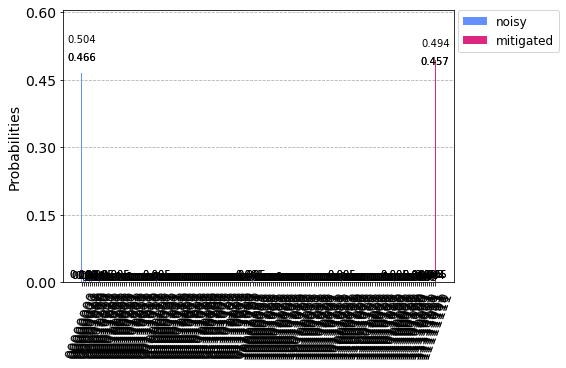

In [183]:
from qiskit.visualization import plot_histogram 
noisy_counts = results.get_counts()
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])